# IMPORTS

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score



## LEITURA DOS DADOS

In [7]:
train_df = pd.read_csv('/home/cid34senhas/Desktop/DAATP/process/Main_Versao/Com CN-MCI/Processamento/DF_CN-MCI_1_After_Pre_Processamento.csv') 
df_test = pd.read_csv('/home/cid34senhas/Desktop/DAATP/process/Main_Versao/Com CN-MCI/Processamento/DF_Test_1_After_Pre_Processamento.csv')
x_train=train_df.drop(columns=['Transition'])

label_mapping = {
    'CN-CN': 0,
    'AD-AD': 1,
    'MCI-AD': 2,
    'MCI-MCI': 3,
    'CN-MCI' : 4
}



# Tratamento

### Normalizar Dados

In [8]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
#df_normalizado = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)




### Correlação com o Target

In [9]:
def remove_highly_correlated_with_target(data, target_column, threshold):
    # Compute the correlation of each column with the target column
    corr_with_target = data.corr()[target_column].abs()
    
    # Identify columns to remove based on correlation with the target
    to_drop = corr_with_target[corr_with_target >= threshold].index
    to_drop = to_drop.drop(target_column)  # Remove target column itself if included
    
    # Drop the identified columns
    data_final = data.drop(columns=to_drop)

    return data_final, to_drop
print(train_df.shape)
train_df, to_drop4 = remove_highly_correlated_with_target(train_df, 'Transition',threshold=0.16)
df_test =  df_test.drop(columns=to_drop4)
print(train_df.shape)
print(df_test.shape)

print("Normalizados:")

#print(df_normalizado.shape)
#df_normalizado, to_drop4 = remove_highly_correlated_with_target(df_normalizado, 'Transition',threshold=0.15)
#print(df_normalizado.shape)



(305, 2014)
(305, 1831)
(100, 1830)
Normalizados:


### Correlação Entre Colunas 

In [10]:
def remove_highly_correlated_features(data, threshold):
    # Compute the correlation matrix
    corr_matrix = data.corr().abs()

    # Identify columns to remove based on correlation
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] >= threshold:
                to_drop.add(corr_matrix.columns[j])

    # Drop the identified columns
    data_final = data.drop(columns=to_drop)

    return data_final, to_drop



print(train_df.shape)
train_df, to_drop5 = remove_highly_correlated_features(train_df,0.95)
df_test =  df_test.drop(columns=to_drop5)

print(train_df.shape)
print(df_test.shape)


(305, 1831)
(305, 868)
(100, 867)


### Desvio Padrão

In [11]:


def remove_low_variance_features(data, threshold=0.01):
    # Remove low variance features
    selector = VarianceThreshold(threshold=threshold)
    low_variance_data = selector.fit_transform(data.select_dtypes(include=['float64', 'int64']))

    # Get the columns to keep
    retained_columns = data.select_dtypes(include=['float64', 'int64']).columns[selector.get_support(indices=True)]

    # Create a DataFrame with the retained columns
    data_reduced = pd.DataFrame(low_variance_data, columns=retained_columns)

    return data_reduced
print(train_df.shape)
#df = remove_low_variance_features(df)
print(train_df.shape)


(305, 868)
(305, 868)


In [12]:
# *!  df.to_csv('DF_1_After_Pre_Processamento.csv', index=False)
# *! ## df_test.to_csv('DF_Test_1_After_Pre_Processamento.csv', index=False)


Positive kurtosis: 806
Negative kurtosis: 79
Zero kurtosis: 1128


/tmp/ipykernel_427962/3791118126.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outliers['Transition'] = train_df['Transition']


Shape of x_train after removing low variance and highly correlated features: (305, 868)
Positive skewness: 538
Negative skewness: 109
Zero skewness: 1366
(305, 2013)


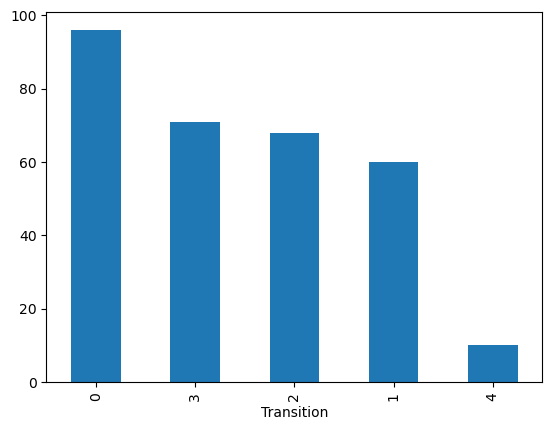

In [13]:
def calculate_skewness(df):
    skew = df.skew()
    skew_pos = skew[skew > 1]
    skew_neg = skew[skew < -1]
    skew_zero = skew[(skew >= -1) & (skew <= 1)]
    print(f"Positive skewness: {len(skew_pos)}")
    print(f"Negative skewness: {len(skew_neg)}")
    print(f"Zero skewness: {len(skew_zero)}")
    return skew_pos, skew_neg, skew_zero

def treat_skewness(df):
    skew_pos, skew_neg, skew_zero = calculate_skewness(df)
    
    # Apply log transformation to features with positive skewness
    # Adding a small constant to avoid issues with log(0)
    for col in skew_pos.index:
        df[col] = np.log1p(df[col])  # log1p is log(1 + x), helps avoid log(0)
    
    # Apply cube root transformation to features with negative skewness
    for col in skew_neg.index:
        df[col] = np.cbrt(df[col])
    
    return df

def calculate_kurtosis(df):
    kurt = df.kurtosis()
    kurt_pos = kurt[kurt > 1]
    kurt_neg = kurt[kurt < -1]
    kurt_zero = kurt[(kurt >= -1) & (kurt <= 1)]
    print(f"Positive kurtosis: {len(kurt_pos)}")
    print(f"Negative kurtosis: {len(kurt_neg)}")
    print(f"Zero kurtosis: {len(kurt_zero)}")
    return kurt_pos, kurt_neg, kurt_zero

kurt_pos, kurt_neg, kurt_zero = calculate_kurtosis(x_train)

# This involves handle outliers
# Indetify outliers only with IQR method
Q1 = x_train.quantile(0.25)
Q3 = x_train.quantile(0.75)
IQR = Q3 - Q1
outliers = (x_train < (Q1 - 1.5 * IQR)) | (x_train > (Q3 + 1.5 * IQR))

# Check if the number of outliers for each label class
outliers['Transition'] = train_df['Transition']
outliers = outliers[outliers.any(axis=1)]
outliers['Transition'].value_counts().plot(kind='bar')

print(f"Shape of x_train after removing low variance and highly correlated features: {train_df.shape}")

x_skeness = treat_skewness(x_train)

# Apply standard scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_skeness)

print(x_train.shape)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)


# MODELOS

In [14]:
# Separar as features e o target
#X = df.drop('Transition', axis=1)
#y = df['Transition']



# Dividir o conjunto de dados em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(x_train, train_df['Transition'], test_size=0.25, random_state=34, stratify=train_df['Transition'])


# Inicializar dicionário para armazenar as pontuações de cross-validation do modelo
model_cross_score = {}
model_f1_macro = {}


### Funcao Axuliar: Matrix de Confusão

In [15]:
import seaborn as sns
def plot_confusion_matrix_with_labels(confusion_matrix, label_mapping):
    # Criar um mapeamento inverso
    reverse_label_mapping = {v: k for k, v in label_mapping.items()}
    
    # Aplicar o mapeamento inverso na matriz de confusão
    cm_with_labels = np.zeros_like(confusion_matrix, dtype=object)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            cm_with_labels[i, j] = f"{reverse_label_mapping[i]} (Pred: {reverse_label_mapping[j]})"

    # Criar um DataFrame para facilitar a visualização
    df_cm = pd.DataFrame(confusion_matrix, index=reverse_label_mapping.values(), columns=reverse_label_mapping.values())
    
    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix with Labels')
    plt.show()

## Random Forest Classifier

### Score

              precision    recall  f1-score   support

           0       0.55      0.67      0.60        24
           1       0.42      0.53      0.47        15
           2       0.06      0.06      0.06        17
           3       0.33      0.22      0.27        18
           4       0.00      0.00      0.00         3

    accuracy                           0.38        77
   macro avg       0.27      0.30      0.28        77
weighted avg       0.34      0.38      0.36        77



/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

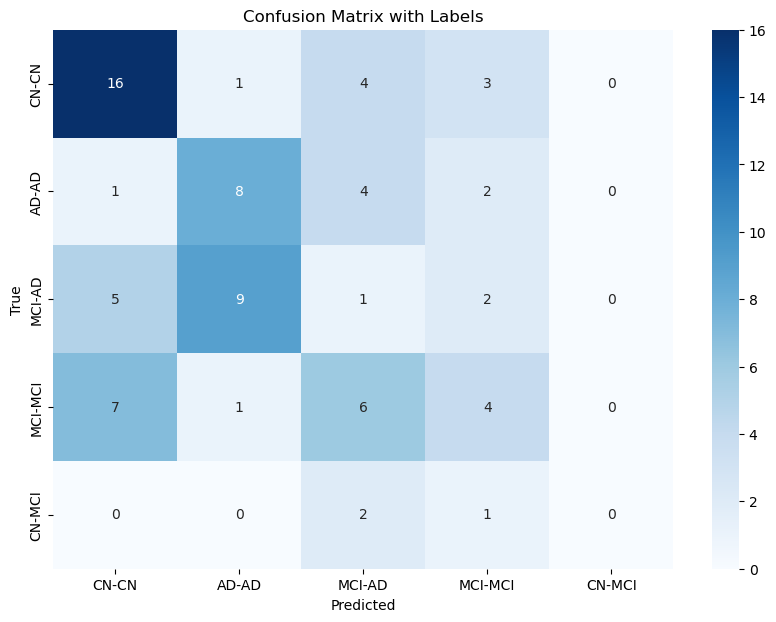

In [16]:
rf_model_score = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=34)


rf_model_score.fit(X_train, y_train)
rf_pred = rf_model_score.predict(X_test)
rf_f1_macro = f1_score(y_test, rf_pred, average='macro')
model_f1_macro['random_forest'] = rf_f1_macro
print(classification_report(y_test, rf_pred))
cm = confusion_matrix(y_test, rf_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)

### Cross Validation Score 

In [17]:

rf_model = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=34)

rf_score = cross_val_score(rf_model, X_train, y_train, cv=5,scoring='f1_macro').mean()

model_cross_score['random_forest'] = rf_score


## Extra Trees Classifier

### Score

              precision    recall  f1-score   support

           0       0.52      0.71      0.60        24
           1       0.53      0.53      0.53        15
           2       0.19      0.24      0.21        17
           3       0.12      0.06      0.08        18
           4       0.00      0.00      0.00         3

    accuracy                           0.39        77
   macro avg       0.27      0.31      0.28        77
weighted avg       0.34      0.39      0.35        77



/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

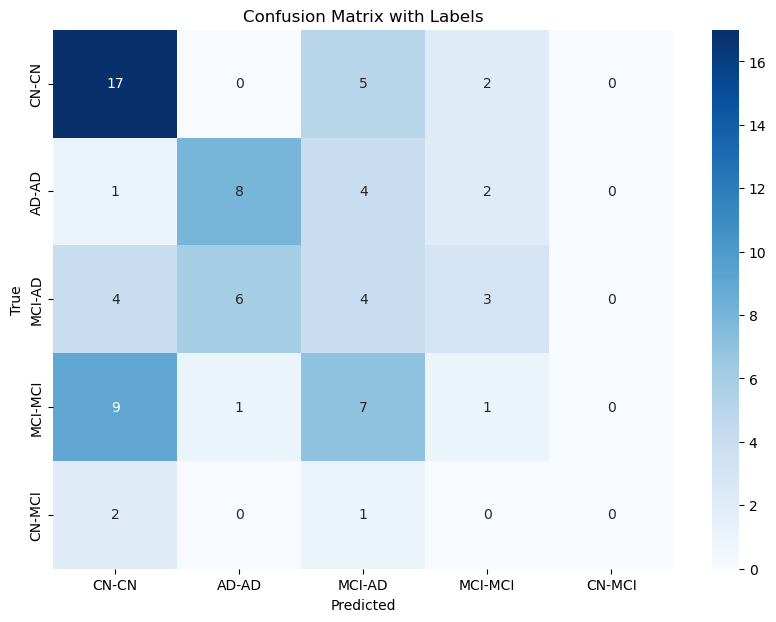

In [18]:
et_model_score = ExtraTreesClassifier(criterion='gini', max_depth=20, random_state=34)


et_model_score.fit(X_train, y_train)
et_pred = et_model_score.predict(X_test)
et_f1_macro = f1_score(y_test, et_pred, average='macro')
model_f1_macro['extra_trees'] = et_f1_macro

print(classification_report(y_test,et_pred))
cm = confusion_matrix(y_test,et_pred)
plot_confusion_matrix_with_labels(cm, label_mapping)



### Cross Validation Score

In [19]:
et_model = ExtraTreesClassifier(criterion='gini', max_depth=20, random_state=34)

model_cross_score['Extra Trees'] = cross_val_score(et_model, X_train, y_train, cv=5,scoring='f1_macro').mean()

print(model_cross_score['Extra Trees'])

0.3100701273017892


## Gradient Boosting Classifier 

### Score

              precision    recall  f1-score   support

           0       0.57      0.67      0.62        24
           1       0.50      0.53      0.52        15
           2       0.09      0.06      0.07        17
           3       0.15      0.17      0.16        18
           4       0.00      0.00      0.00         3

    accuracy                           0.36        77
   macro avg       0.26      0.29      0.27        77
weighted avg       0.33      0.36      0.35        77



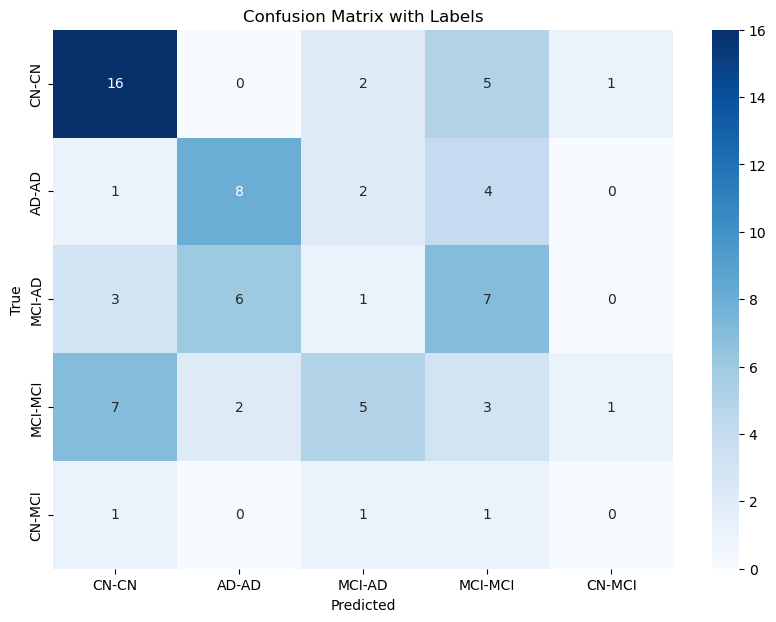

In [20]:
gb_model_score = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=34)


gb_model_score.fit(X_train, y_train)
gb_pred = gb_model_score.predict(X_test)
gb_f1_macro = f1_score(y_test, gb_pred, average='macro')
model_f1_macro['Gradient Boosting'] = gb_f1_macro


print(classification_report(y_test,gb_pred))
cm = confusion_matrix(y_test,gb_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)



### Cross Validation Score

In [21]:
gb_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=34)

score_cross = cross_val_score(gb_model,X_train,y_train,cv=5,scoring='f1_macro').mean()

print(score_cross)

model_cross_score['Gradient_boosting'] = score_cross



0.32641304827730344


#### K Neighbors Classifier

### Score

              precision    recall  f1-score   support

           0       0.53      0.79      0.63        24
           1       0.44      0.53      0.48        15
           2       0.15      0.12      0.13        17
           3       0.30      0.17      0.21        18
           4       0.00      0.00      0.00         3

    accuracy                           0.42        77
   macro avg       0.29      0.32      0.29        77
weighted avg       0.36      0.42      0.37        77



/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

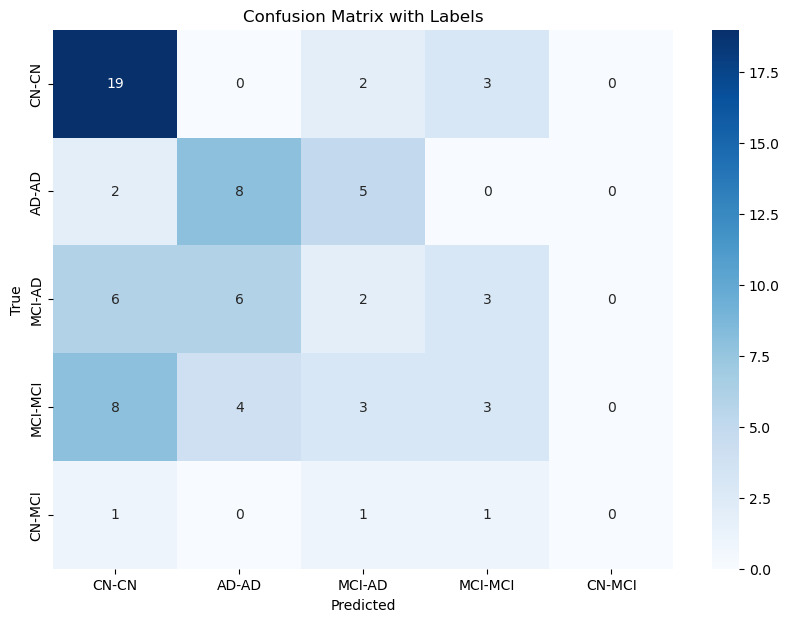

In [22]:
kn_model_score = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')


kn_model_score.fit(X_train, y_train)
kn_pred = kn_model_score.predict(X_test)
kn_f1_macro = f1_score(y_test, kn_pred, average='macro')
model_f1_macro['K neightbors'] = kn_f1_macro


print(classification_report(y_test,kn_pred))
cm = confusion_matrix(y_test,kn_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)


### Cross Validation Score

In [23]:
kn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')

k_night_croos_score = cross_val_score(kn_model, X_train, y_train, cv=10,scoring='f1_macro')

print("Acuracy k night", k_night_croos_score.mean())

model_cross_score['k_night'] = k_night_croos_score.mean()


Acuracy k night 0.3464686422109023


/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


#### Extreme Gradient Boosting

### Score

              precision    recall  f1-score   support

           0       0.53      0.71      0.61        24
           1       0.47      0.47      0.47        15
           2       0.17      0.18      0.17        17
           3       0.25      0.17      0.20        18
           4       0.00      0.00      0.00         3

    accuracy                           0.39        77
   macro avg       0.28      0.30      0.29        77
weighted avg       0.35      0.39      0.36        77



/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

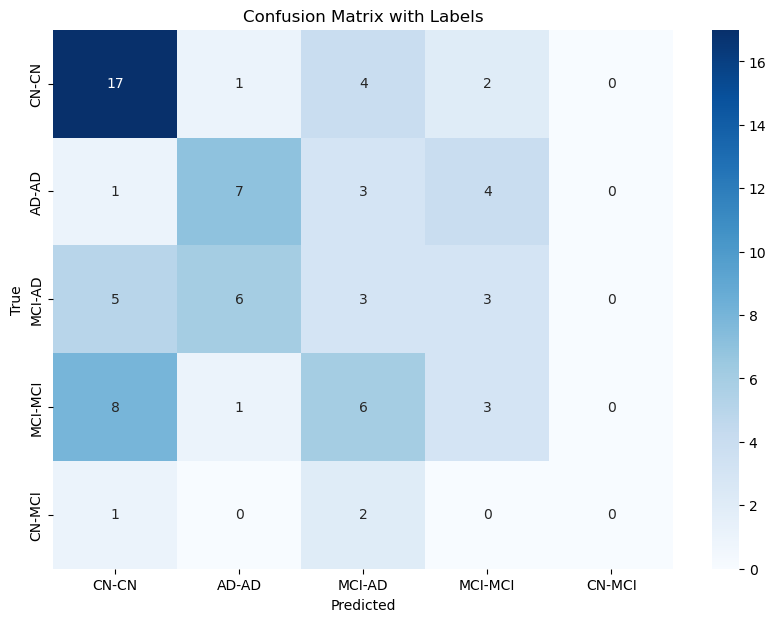

In [24]:
from xgboost import XGBClassifier


xgb_model_score = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05,colsample_bytree=0.4, subsample=0.8, random_state=34)



xgb_model_score.fit(X_train, y_train)
xgb_pred = xgb_model_score.predict(X_test)
xgb_f1_macro = f1_score(y_test, xgb_pred, average='macro')
model_f1_macro['xgBoost'] = xgb_f1_macro

print(classification_report(y_test,xgb_pred))
cm = confusion_matrix(y_test,xgb_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)



### Cross Validation Score

In [25]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05,colsample_bytree=0.4, subsample=0.8, random_state=34)


score_cross = cross_val_score(xgb_model,X_train,y_train,cv=5,scoring='f1_macro').mean()

print(score_cross)

model_cross_score['XGBoost'] = score_cross



0.30013490561272793


## SVC

### Score

              precision    recall  f1-score   support

           0       0.53      0.71      0.61        24
           1       0.47      0.47      0.47        15
           2       0.17      0.18      0.17        17
           3       0.25      0.17      0.20        18
           4       0.00      0.00      0.00         3

    accuracy                           0.39        77
   macro avg       0.28      0.30      0.29        77
weighted avg       0.35      0.39      0.36        77



/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cid34senhas/miniconda3/envs/DAA123/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

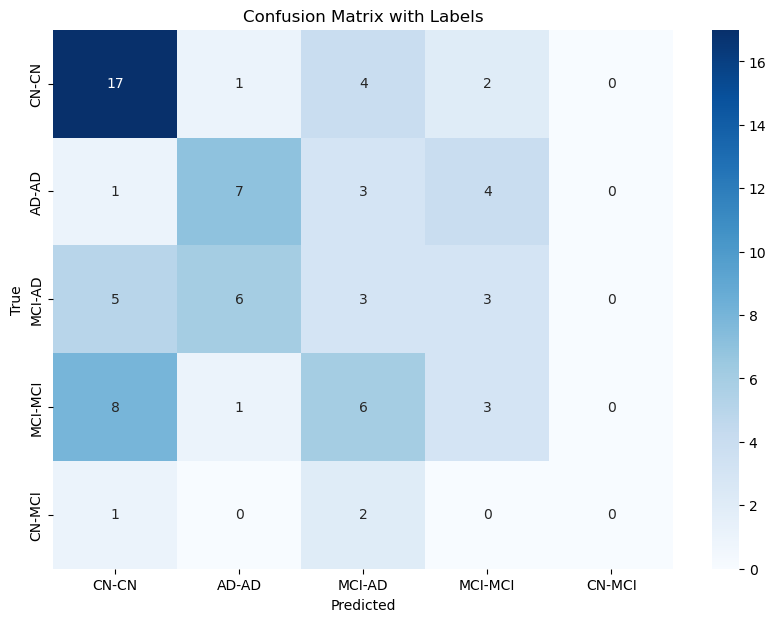

In [26]:
svc_moldel_score = SVC(kernel='rbf', random_state=34)



svc_moldel_score.fit(X_train, y_train)
svc_pred = svc_moldel_score.predict(X_test)
svc_f1_macro = f1_score(y_test, svc_pred, average='macro')
model_f1_macro['SVC'] = svc_f1_macro

print(classification_report(y_test,xgb_pred))
cm = confusion_matrix(y_test,xgb_pred)
plot_confusion_matrix_with_labels(cm,label_mapping)



### Cross Validation Score

In [27]:


svc_moldel = SVC(kernel='rbf', random_state=34)


score_cross = cross_val_score(xgb_model,X_train,y_train,cv=5,scoring='f1_macro').mean()

print(score_cross)

model_cross_score['SVC'] = score_cross



0.30013490561272793


Model                Accuracy
------------------------------
K Neighbors Classifier     0.4156
Extra Trees Classifier     0.3896
Extreme Gradient Boosting     0.3896
SCV                      0.3896
Random Forest Classifier     0.3766
Gradient Boosting Classifier     0.3636


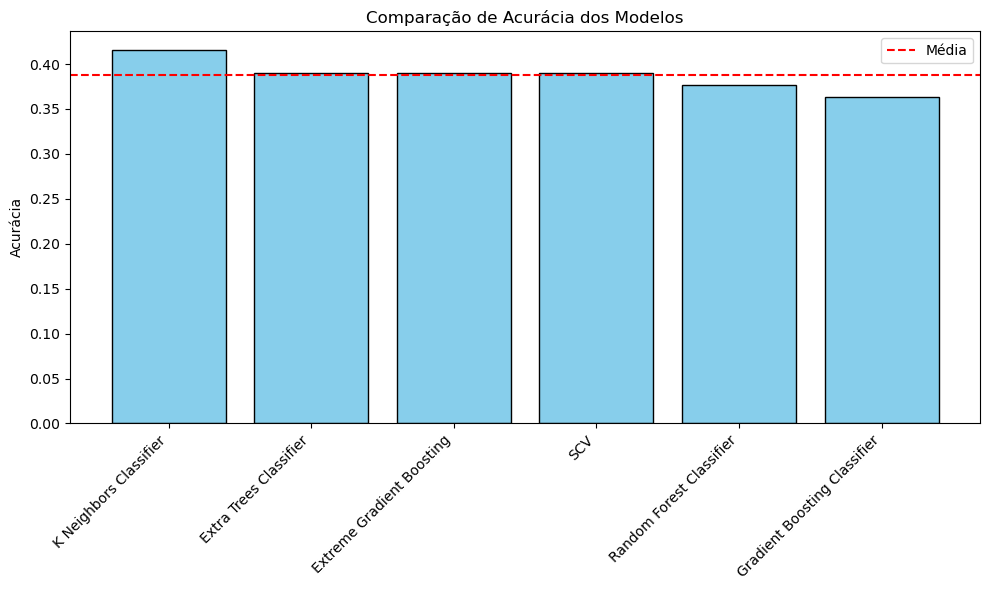

Model                F1-macro
------------------------------
K Neighbors Classifier     0.2932
Extreme Gradient Boosting     0.2890
Extra Trees Classifier     0.2835
Random Forest Classifier     0.2800
Gradient Boosting Classifier     0.2722
SCV                      0.2377


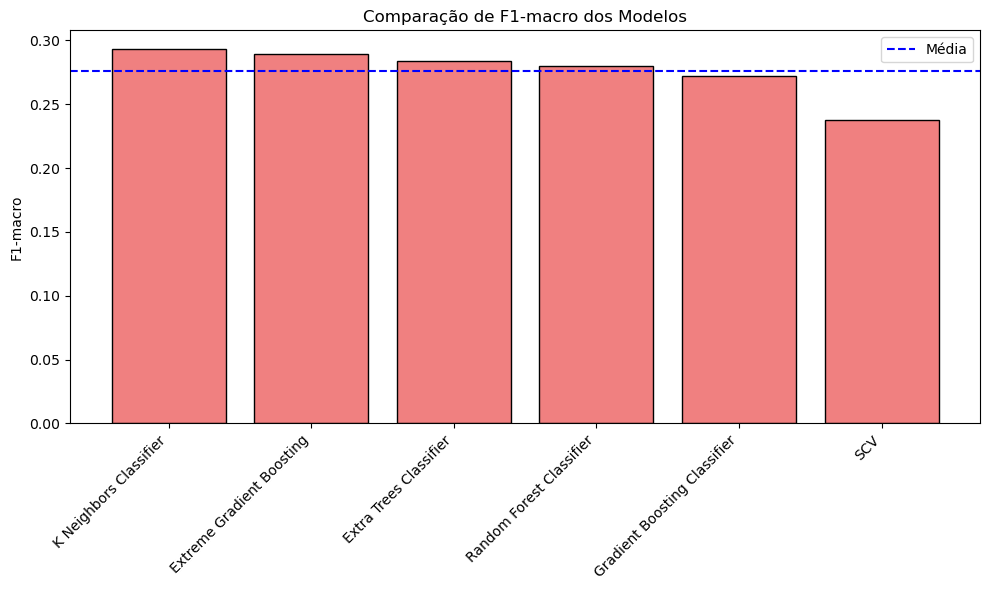

Model                          Cross-Validation Score
---------------------------------------------
k_night                            0.3465
random_forest                      0.3330
Gradient_boosting                  0.3264
Extra Trees                        0.3101
XGBoost                            0.3001
SVC                                0.3001


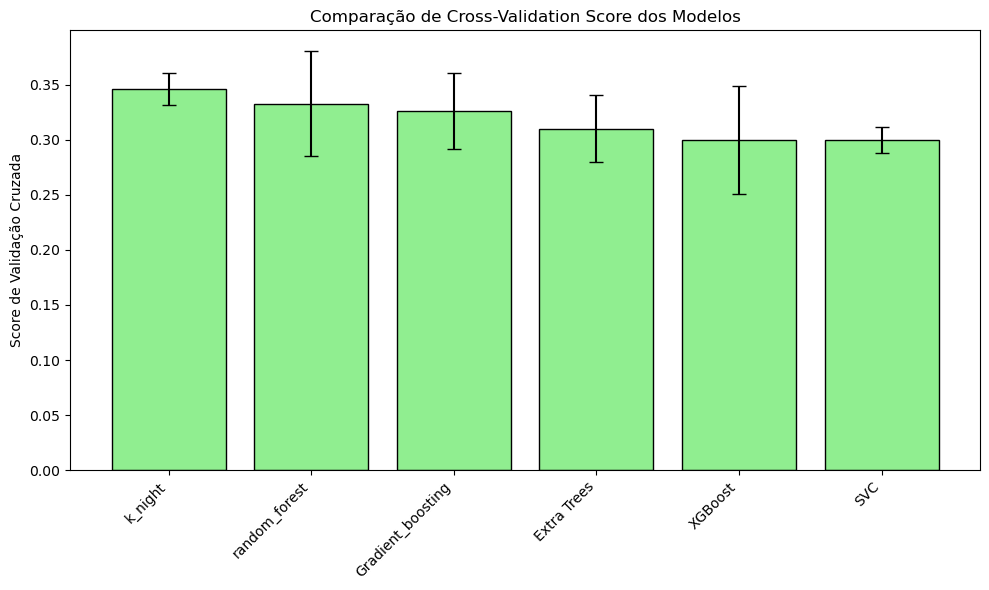

In [28]:


# Função para comparar modelos e criar gráfico com acurácia
def compare_models(Y_test, predictions):
    model_accuracies = {}

    # Calcular acurácia de cada modelo
    for name, prediction in predictions.items():
        accuracy = sum(prediction == Y_test) / len(Y_test)
        model_accuracies[name] = accuracy

    # Ordenar os modelos por acurácia em ordem decrescente
    sorted_models = sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True)

    # Imprimir a tabela
    print("Model".ljust(20), "Accuracy")
    print("-" * 30)
    for model, accuracy in sorted_models:
        print(model.ljust(20), f"{accuracy:.4f}".rjust(10))

    # Gerar gráfico de barras
    models = [model for model, _ in sorted_models]
    accuracies = [accuracy for _, accuracy in sorted_models]

    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color="skyblue", edgecolor="black")
    plt.axhline(y=np.mean(accuracies), color='red', linestyle='--', label="Média")
    plt.title("Comparação de Acurácia dos Modelos")
    plt.ylabel("Acurácia")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()



# Função para comparar scores de validação cruzada e criar gráfico
def compare_models_cross_score(model_cross_score):
    # Ordenar modelos por score em ordem decrescente
    sorted_models = sorted(model_cross_score.items(), key=lambda x: x[1], reverse=True)

    # Imprimir a tabela
    print("Model".ljust(30), "Cross-Validation Score")
    print("-" * 45)
    for model, score in sorted_models:
        print(model.ljust(30), f"{score:.4f}".rjust(10))

    # Gerar gráfico de barras com variância
    models = [model for model, _ in sorted_models]
    scores = [score for _, score in sorted_models]

    # Simulação de variância (se você já tiver, substitua pelo real)
    variances = np.random.uniform(0.01, 0.05, len(scores))

    plt.figure(figsize=(10, 6))
    plt.bar(models, scores, yerr=variances, capsize=5, color="lightgreen", edgecolor="black")
    plt.title("Comparação de Cross-Validation Score dos Modelos")
    plt.ylabel("Score de Validação Cruzada")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()




def compare_models_f1_macro(Y_test, predictions):
    model_f1_scores = {}

    # Calcular o F1-macro para cada modelo
    for name, prediction in predictions.items():
        f1_macro = f1_score(Y_test, prediction, average='macro')
        model_f1_scores[name] = f1_macro

    # Ordenar os modelos por F1-macro em ordem decrescente
    sorted_models = sorted(model_f1_scores.items(), key=lambda x: x[1], reverse=True)

    # Imprimir a tabela
    print("Model".ljust(20), "F1-macro")
    print("-" * 30)
    for model, f1_macro in sorted_models:
        print(model.ljust(20), f"{f1_macro:.4f}".rjust(10))

    # Gerar gráfico de barras
    models = [model for model, _ in sorted_models]
    f1_scores = [f1_macro for _, f1_macro in sorted_models]

    plt.figure(figsize=(10, 6))
    plt.bar(models, f1_scores, color="lightcoral", edgecolor="black")
    plt.axhline(y=np.mean(f1_scores), color='blue', linestyle='--', label="Média")
    plt.title("Comparação de F1-macro dos Modelos")
    plt.ylabel("F1-macro")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Exemplo de uso
predictions = {
    'Random Forest Classifier': rf_pred,
    'Extra Trees Classifier': et_pred,
    'Gradient Boosting Classifier': gb_pred,
    'K Neighbors Classifier': kn_pred,
    'Extreme Gradient Boosting': xgb_pred,
    'SCV':svc_pred
}


compare_models(y_test, predictions)
compare_models_f1_macro(y_test,predictions)
compare_models_cross_score(model_cross_score)

